In [1]:
!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['JOBLIB_LOKY_BACKEND'] = 'threading'
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

# Load Data --
plt.style.use('ggplot') # Set plot style

# Load the dataset
file_path = 'Mall_Customers.csv'
df = pd.read_csv(file_path)

# Display basic info and first few rows
print(df.info())
print("\n")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [4]:
# Preprocessing ---

print(f"Number of duplicate rows: {df.duplicated().sum()}")

X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled[:5])

Number of duplicate rows: 0

Feature scaling complete. First 5 scaled rows:
[[-1.73899919 -0.43480148]
 [-1.73899919  1.19570407]
 [-1.70082976 -1.71591298]
 [-1.70082976  1.04041783]
 [-1.66266033 -0.39597992]]



--- Automatically Found Optimal K: 5 ---
Elbow method plot saved as 'elbow_plot_automatic.png'.


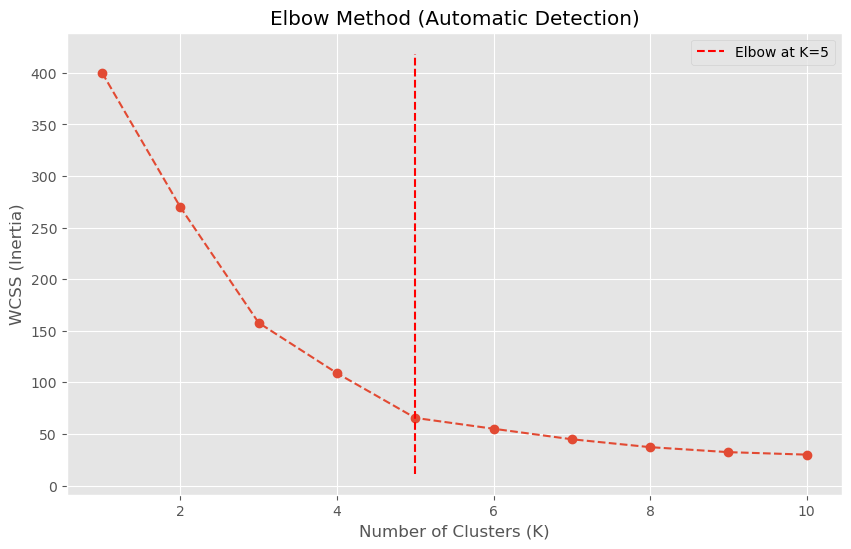

In [7]:
# Find Optimal K (Elbow Method) ---

wcss = [] # Within-Cluster Sum of Squares
k_values = range(1, 11) # Define the range of K

for i in k_values:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Automatic K Calculation using KneeLocator ---
kneedle = KneeLocator(
    k_values, 
    wcss, 
    curve='convex', 
    direction='decreasing'
)

optimal_k = kneedle.elbow

print(f"\n--- Automatically Found Optimal K: {optimal_k} ---")


# Visualization
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')

# Plot a vertical red line at the automatically found "elbow"
if optimal_k:
    plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r', label=f'Elbow at K={optimal_k}')

plt.title('Elbow Method (Automatic Detection)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.legend()
plt.grid(True)

In [13]:
# Apply K-Means Clustering ---

k = optimal_k 

kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
y_kmeans = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df['Cluster'] = y_kmeans

print(df.head())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster  
0        4  
1        2  
2        4  
3        2  
4        4  


Cluster visualization saved as 'kmeans_clusters_visualization.png'.


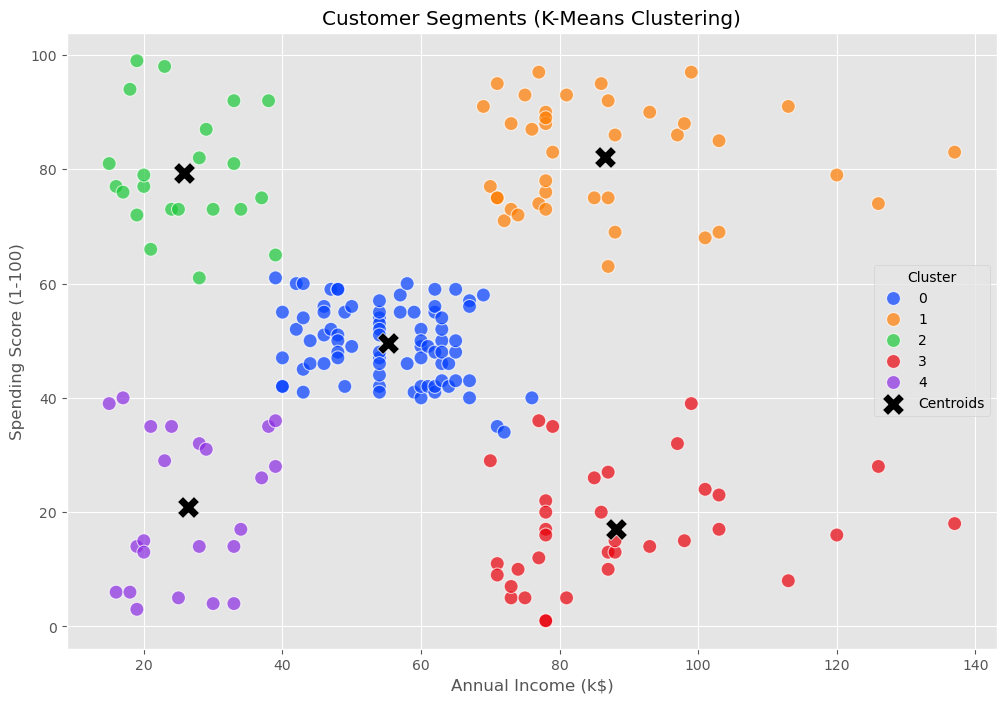

In [15]:
# Visualize Clusters ---
# Inverse transform cluster centers to original scale
centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Create the scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df,
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Cluster',
    palette=sns.color_palette('bright', n_colors=k),
    s=100, # Set size
    alpha=0.7, # Set transparency
    legend='full'
)

# Plot cluster centers
plt.scatter(
    centers[:, 0], centers[:, 1],
    s=250, # Set size for centers
    marker='X', # Set marker
    c='black',
    edgecolor='white',
    label='Centroids'
)

plt.title('Customer Segments (K-Means Clustering)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('kmeans_clusters_visualization.png')

print("Cluster visualization saved as 'kmeans_clusters_visualization.png'.")

Displaying Iteration 1...


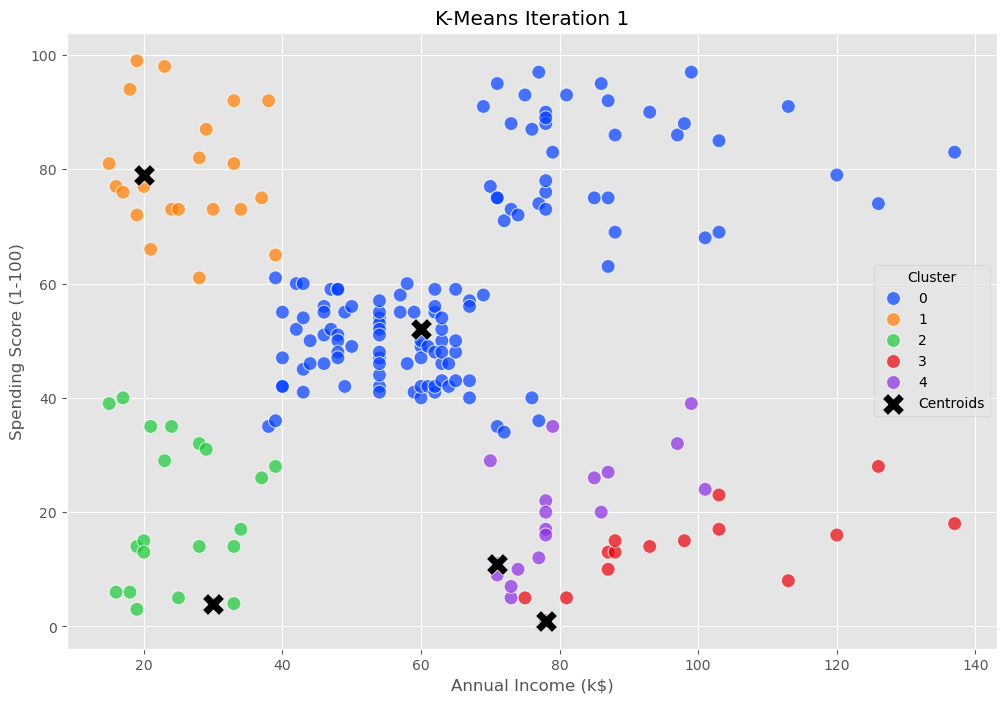

Displaying Iteration 2...


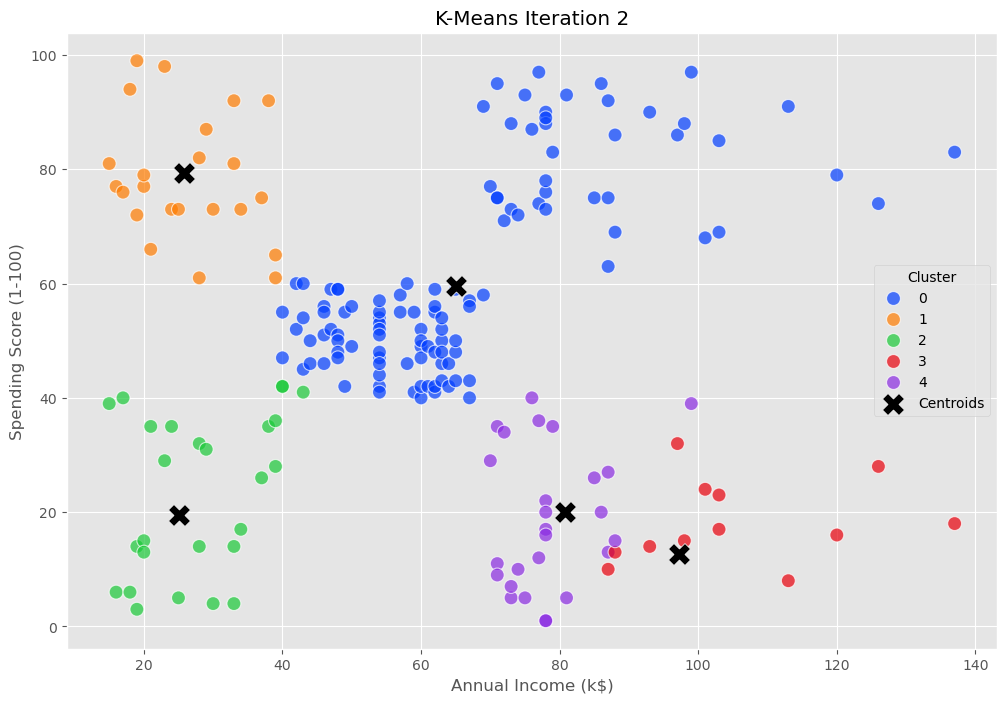

Displaying Iteration 3...


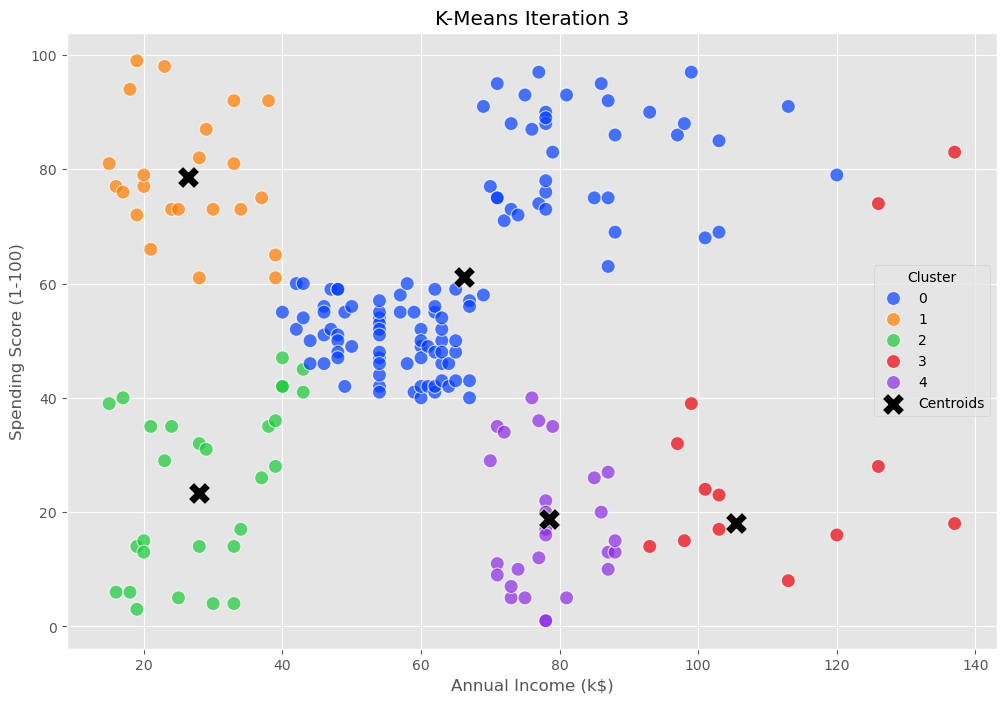

Displaying Iteration 4...


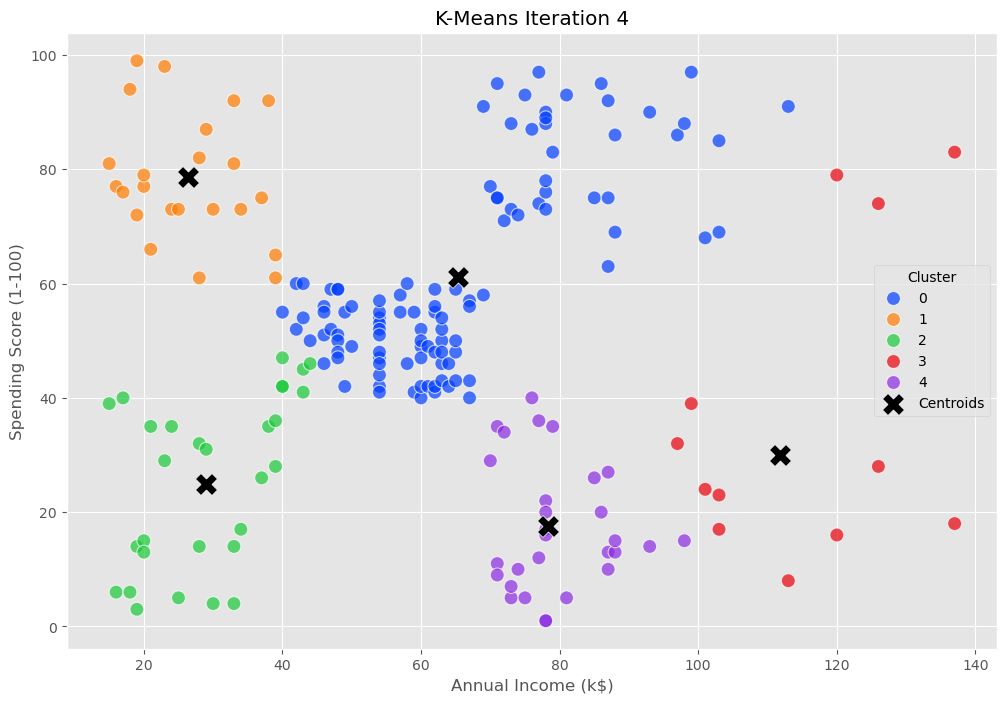

Displaying Iteration 5...


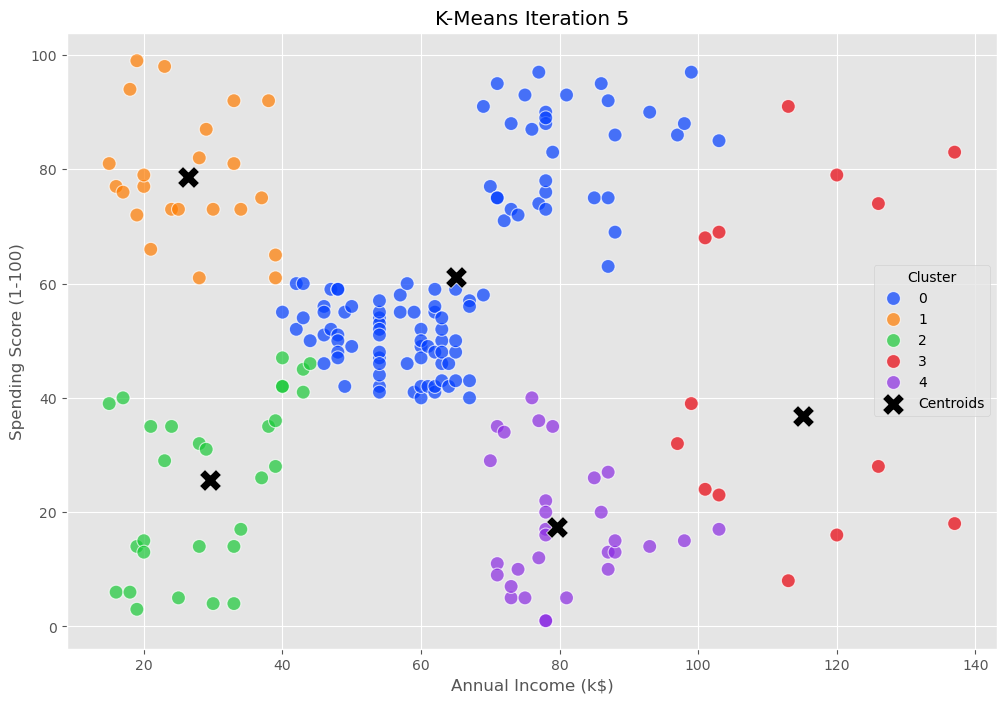

Displaying Iteration 6...


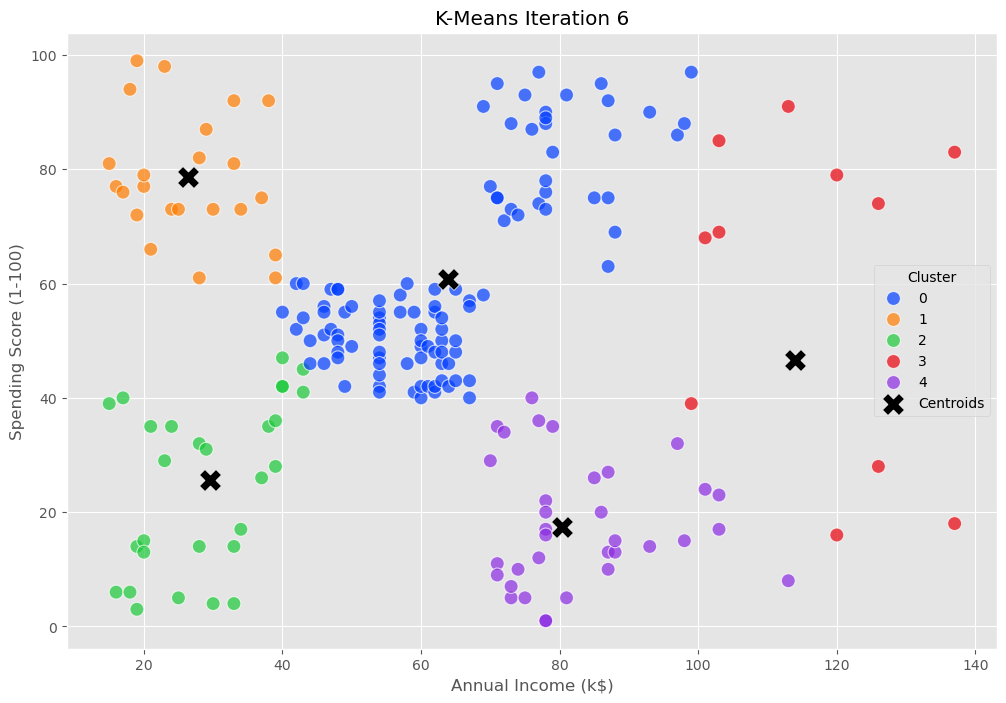

Displaying Iteration 7...


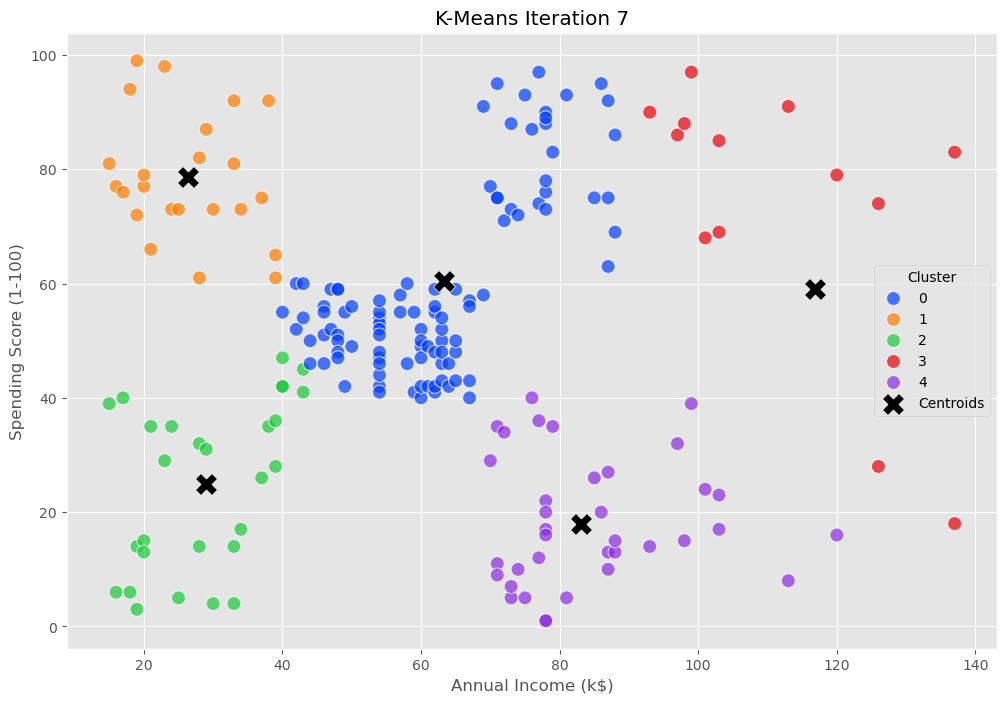

Displaying Iteration 8...


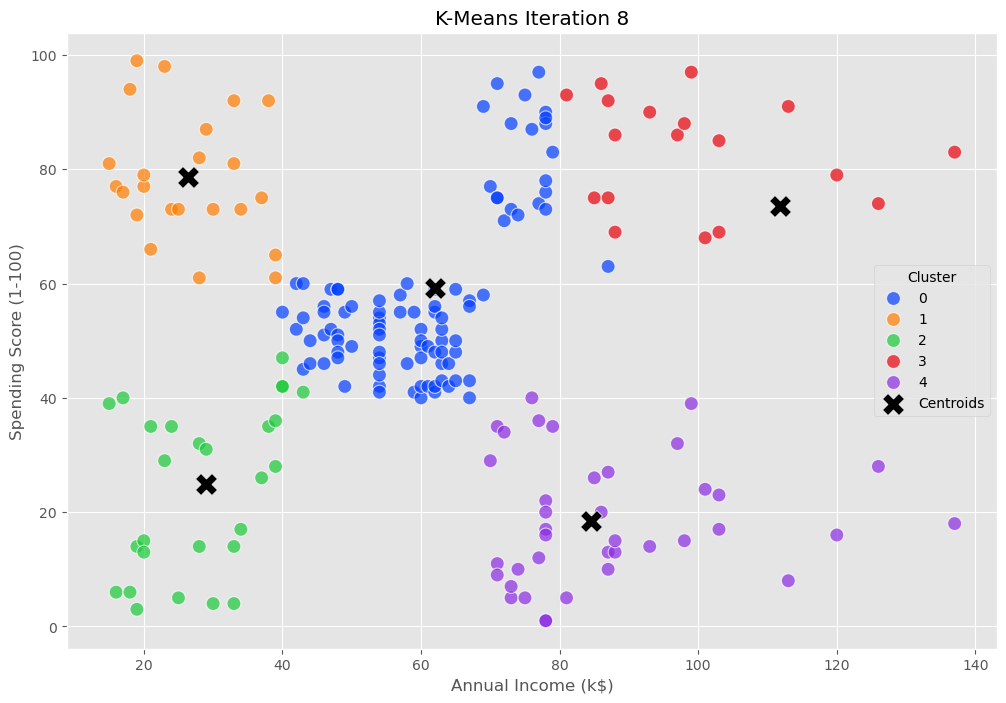

Displaying Iteration 9...


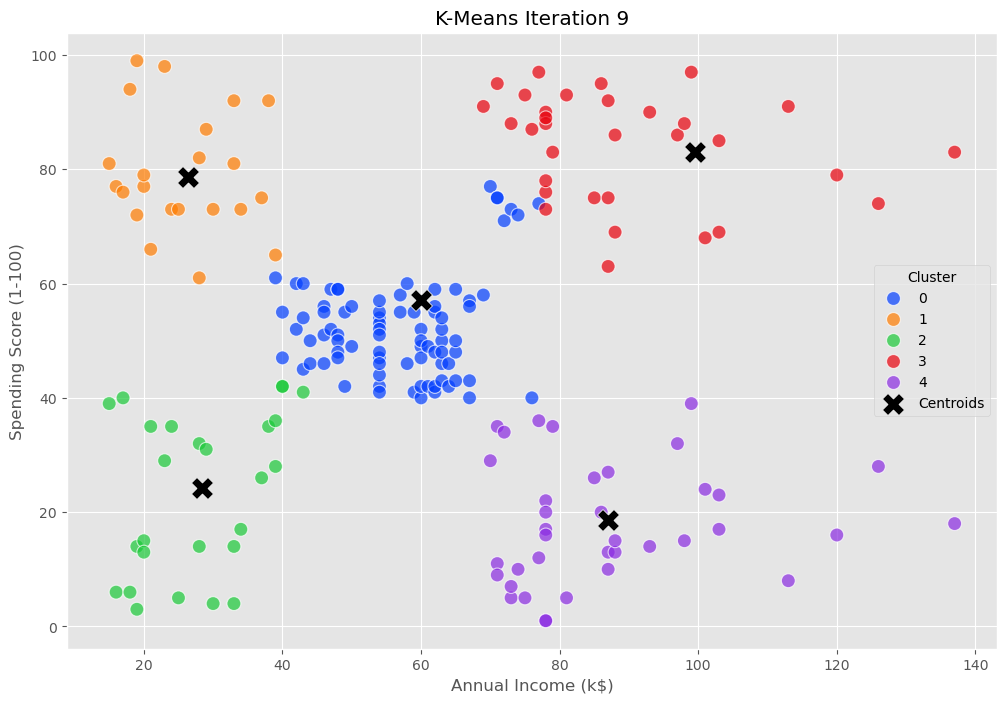

Displaying Iteration 10...


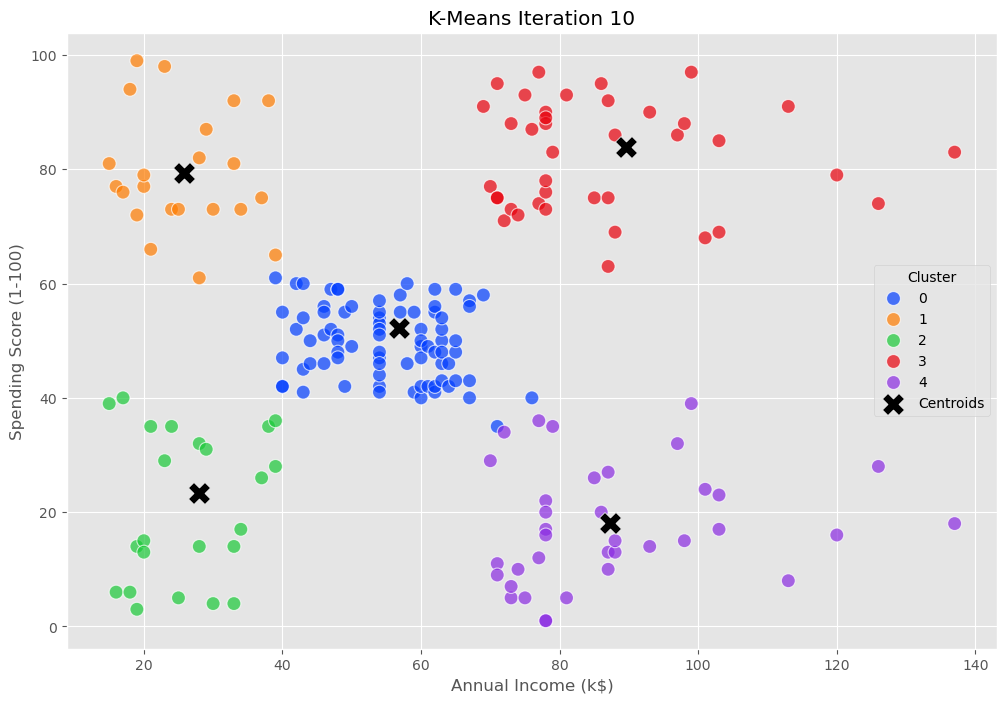

Displaying Iteration 11...


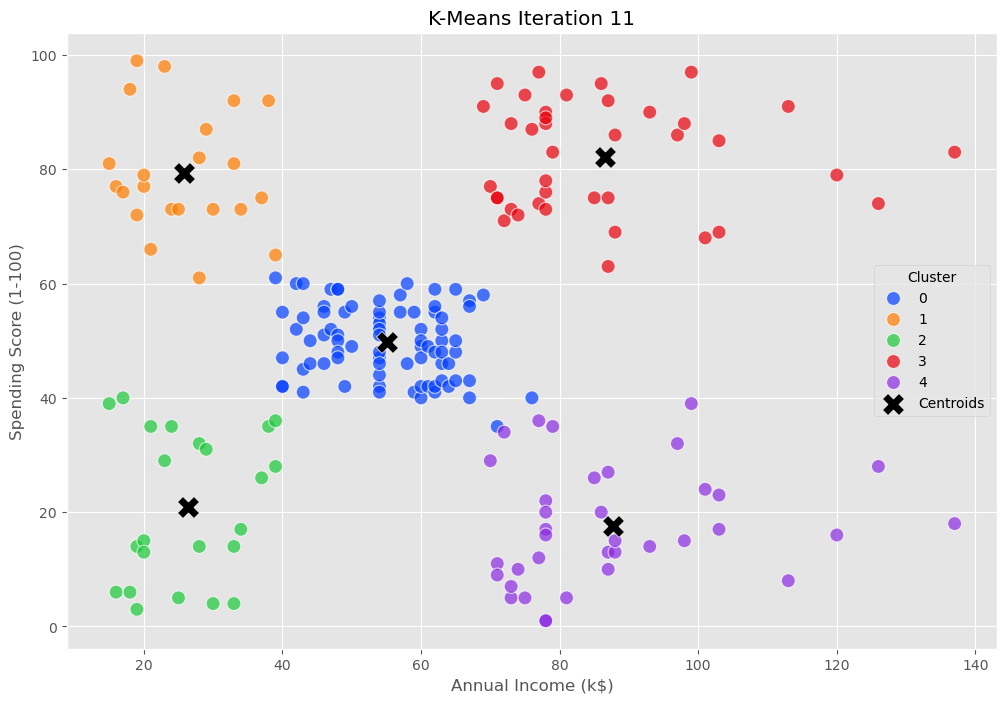


Convergence reached at iteration 11.


In [21]:
np.random.seed(42)

# 1. Initialization: Select K random points as initial centroids
indices = np.random.choice(X_scaled.shape[0], k, replace=False)
centroids = X_scaled[indices]

iteration_count = 0
max_iterations = 300 # Set a safety limit

while True: # Loop until convergence or max_iterations
    iteration_count += 1

    #  Calculate distances from each point to all centroids
    distances = np.linalg.norm(X_scaled[:, np.newaxis] - centroids, axis=2)

    # Find the index of the closest centroid for each point
    labels = np.argmin(distances, axis=1)

    df['Cluster'] = labels # Update DataFrame with current labels for plotting

    # Inverse transform centroids to original scale for plotting
    centers_orig = scaler.inverse_transform(centroids)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df,
        x='Annual Income (k$)',
        y='Spending Score (1-100)',
        hue='Cluster',
        palette=sns.color_palette('bright', n_colors=k),
        s=100,
        alpha=0.7,
        legend='full'
    )
    plt.scatter(
        centers_orig[:, 0], centers_orig[:, 1],
        s=250, marker='X', c='black',
        edgecolor='white', label='Centroids'
    )
    plt.title(f'K-Means Iteration {iteration_count}') 
    plt.xlabel('Annual Income (k$)')
    plt.ylabel('Spending Score (1-100)')
    plt.legend(title='Cluster')
    plt.grid(True)

    plt.show() 

    # 3. Update Step: Calculate the mean of all points assigned to each cluster
    new_centroids = np.array([X_scaled[labels == j].mean(axis=0) for j in range(k)])

    # 4. Check for Convergence:
    # Handle empty clusters (where mean results in NaN)
    if np.isnan(new_centroids).any():
        print(f"Iteration {iteration_count}: Encountered empty cluster. Stopping.")
        break
    
    # Stop if the centroids have not moved
    if np.allclose(centroids, new_centroids):
        print(f"\nConvergence reached at iteration {iteration_count}.")
        break
    
    # Stop if we hit the safety limit
    if iteration_count >= max_iterations:
        print(f"\nReached max_iterations ({max_iterations}) without convergence.")
        break
    
    # If not converged, update centroids for the next loop
    centroids = new_centroids